In [1]:
# Using Transfer Learning 

# InceptionV3 Architecture without data augmentation.

In [1]:
import tensorflow 
import numpy as np
import pickle
import cv2
import keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, InputLayer, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops
ops.get_default_graph()

Using TensorFlow backend.


In [2]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil

#from skimage.io import imread
#from skimage.transform import resize
# Don't use skimage, it sucks (Can't read all iamges). Cv2 is better. 

In [3]:
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9978370111239780543
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2261976346142394280
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3342729216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14962639650102195449
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5357958589727931811
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
config = tensorflow.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tensorflow.compat.v1.Session(config=config) 
tensorflow.compat.v1.keras.backend.set_session(sess)

In [7]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 16
default_image_size = tuple((299, 299))
image_size = 0
directory_root = '../../../../Datasets/PlantVillage-Dataset-master/raw/color/' # Can be deleted
width=299
height=299
depth=3

In [8]:
train_dir = '../../../../Datasets/PlantVillage-Dataset-master/raw/color/'
dest_dir = '../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/'

In [9]:
# Only run one time
counter = 0

for subdir, dirs, files in os.walk(train_dir):
    #print(files)
    for file in files:
        full_path = os.path.join(subdir, file)
        shutil.copy(full_path, dest_dir)
        counter = counter + 1
print(counter)

54305


In [9]:
subdirs, dirs, files = os.walk('../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/').__next__()
m = len(files)
print(m)

filenames = []
labels = np.zeros((m, 1))

#import os
#import shutil

images_dir = '../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/'
filenames_counter = 0
labels_counter = -1
label_names = [] # For post processing

for subdir, dirs, files in os.walk(train_dir):
    #print(files)
    for file in files:
        filenames.append(file)
        labels[filenames_counter, 0] = labels_counter
        filenames_counter = filenames_counter + 1
    labels_counter = labels_counter+1
    label_names.append(dirs) # For post processing
    
del label_names[1:] # For post processing    
print(len(filenames))
print(labels.shape)

54305
54305
(54305, 1)


In [10]:
#label_names

[['Tomato___Bacterial_spot',
  'Cherry_(including_sour)___healthy',
  'Grape___healthy',
  'Apple___Apple_scab',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Soybean___healthy',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Tomato___Leaf_Mold',
  'Tomato___Target_Spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  'Potato___Late_blight',
  'Tomato___healthy',
  'Blueberry___healthy',
  'Apple___healthy',
  'Tomato___Late_blight',
  'Raspberry___healthy',
  'Pepper,_bell___Bacterial_spot',
  'Orange___Haunglongbing_(Citrus_greening)',
  'Potato___healthy',
  'Tomato___Early_blight',
  'Strawberry___healthy',
  'Strawberry___Leaf_scorch',
  'Apple___Black_rot',
  'Tomato___Septoria_leaf_spot',
  'Grape___Esca_(Black_Measles)',
  'Peach___healthy',
  'Peach___Bacterial_spot',
  'Tomato___Tomato_mosaic_virus',
  'Potato___Early_blight',
  'Grape___Black_rot',
  'Corn_(maize)___healthy',
  'Pepper,_bell___healthy',
  'Tomat

In [11]:
np.save('label_names.npy', label_names) # For post processing

In [13]:
#label_names = np.load('label_names.npy')
#label_names

In [12]:
#print(filenames[952])

In [13]:
#print(labels[952])

In [14]:
np.save('filenames.npy', filenames)

#import keras
#from keras.utils import to_categorical

# One hot vector representation of labels
y_labels_one_hot = to_categorical(labels)

# saving the y_labels_one_hot array as a .npy file
np.save('y_labels_one_hot.npy', y_labels_one_hot)

In [15]:
from sklearn.utils import shuffle

filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)

# saving the shuffled file.
# you can load them later using np.load().
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('filenames_shuffled.npy', filenames_shuffled)

In [16]:
print("[INFO] Spliting data to train, test")

# Used this line as our filename array is not a numpy array.
filenames_shuffled_numpy = np.array(filenames_shuffled)

x_train, x_test, y_train, y_test = train_test_split(filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.1, random_state = 42) 

[INFO] Spliting data to train, test


In [17]:
print("[INFO] Spliting data to train, validation")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, validation


In [18]:
print("Train Shape")
print(x_train.shape)
print("Validation Shape")
print(x_val.shape)
print("Test Shape")
print(x_test.shape)

Train Shape
(39099,)
Validation Shape
(9775,)
Test Shape
(5431,)


In [19]:
print("Train Shape")
print(y_train.shape)
print("Validation Shape")
print(y_val.shape)
print("Test Shape")
print(y_test.shape)

Train Shape
(39099, 38)
Validation Shape
(9775, 38)
Test Shape
(5431, 38)


In [20]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)

np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)

np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [21]:
# modified generator for cv2 resize error.

class My_Custom_Generator(tensorflow.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    xyz = []
    pqr = []
    
    for i,file_name in enumerate(batch_x):
        try:
            image = cv2.imread('../../../../Datasets/PlantVillage-Dataset-master/raw/color_all_images/' + str(file_name))
            if image is not None :
                image = cv2.resize(image, default_image_size)   
                xyz.append(img_to_array(image))
                pqr.append(batch_y[i])
        except Exception as e:
            print(f"Error : {e}")
            return None
    
    return np.array(xyz)/255.0, np.array(pqr)

In [22]:
my_training_batch_generator = My_Custom_Generator(x_train, y_train, BS)
my_validation_batch_generator = My_Custom_Generator(x_val, y_val, BS)
my_test_batch_generator = My_Custom_Generator(x_test, y_test, BS)

In [23]:
"""
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1 ,shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
"""

'\naug = ImageDataGenerator(\n    rotation_range=25, width_shift_range=0.1,\n    height_shift_range=0.1 ,shear_range=0.2, \n    zoom_range=0.2,horizontal_flip=True, \n    fill_mode="nearest")\n'

In [24]:
inputShape = (height, width, depth)
iv3 = inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape=inputShape)
print(inputShape)

(299, 299, 3)


In [25]:
#output = iv3.layers[-1].output
#output = tensorflow.keras.layers.Flatten()(output)
#iv3_model = Model(iv3.input, output)

#iv3_model.trainable = False
#for layer in iv3_model.layers:
#    layer.trainable = False

In [26]:
out = iv3.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation = 'relu')(out)
#out = Dropout(0.3)(out)
out = Dense(512, activation = 'relu')(out)
#out = Dropout(0.3)(out)
predictions = Dense(38, activation = 'softmax')(out)

iv3_model = Model(inputs = iv3.input, outputs = predictions)

"""
for layer in iv3.layers:
    layer.trainable = False
"""

'\nfor layer in iv3.layers:\n    layer.trainable = False\n'

In [27]:
import pandas as pd
pd.set_option('max_colwidth',-1)
layers = [(layer, layer.name, layer.trainable) for layer in iv3_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd164338f90>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd22405e2d0>,conv2d,True
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7fd21d7b1f90>,batch_normalization,True
3,<tensorflow.python.keras.layers.core.Activation object at 0x7fd19f8c7a90>,activation,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd19f8fac90>,conv2d_1,True
...,...,...,...
310,<tensorflow.python.keras.layers.merge.Concatenate object at 0x7fd088a5b450>,mixed10,True
311,<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd088960190>,global_average_pooling2d,True
312,<tensorflow.python.keras.layers.core.Dense object at 0x7fd088960550>,dense,True
313,<tensorflow.python.keras.layers.core.Dense object at 0x7fd08897af90>,dense_1,True


In [28]:
#model = Sequential()
#model.add(iv3_model) # Adding this line, CRITICAL
# model.add(InputLayer(input_shape=(input_shape,))) # Remove this line, CRITICAL
#model.add(GlobalAveragePooling2D())
#model.add(Dense(512, activation='relu'))#, input_dim=input_shape))
#model.add(Dropout(0.3))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(15, activation='softmax'))
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
iv3_model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ['accuracy'])
          
iv3_model.summary()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
#history = model.fit_generator(x=train_features_vgg, y=y_train,
#                    validation_data=(validation_features_vgg, y_test),
#                    batch_size=BS,
#                    epochs=EPOCHS,
#                    verbose=1)

# simple early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

history = iv3_model.fit_generator(
    generator = my_training_batch_generator,
    validation_data= my_validation_batch_generator,
    #steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1, 
    callbacks=[es]
    )

Epoch 1/50
2444/2444 [==============================] - 2016s 825ms/step - loss: 0.2636 - accuracy: 0.9253 - val_loss: 0.0626 - val_accuracy: 0.9794
Epoch 2/50
2444/2444 [==============================] - 2012s 823ms/step - loss: 0.0669 - accuracy: 0.9798 - val_loss: 0.1127 - val_accuracy: 0.9666
Epoch 3/50
2444/2444 [==============================] - 1989s 814ms/step - loss: 0.0533 - accuracy: 0.9835 - val_loss: 0.0505 - val_accuracy: 0.9852
Epoch 4/50
2444/2444 [==============================] - 1995s 816ms/step - loss: 0.0419 - accuracy: 0.9869 - val_loss: 0.0409 - val_accuracy: 0.9890
Epoch 5/50
2444/2444 [==============================] - 1992s 815ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0639 - val_accuracy: 0.9849
Epoch 6/50
2444/2444 [==============================] - 1992s 815ms/step - loss: 0.0333 - accuracy: 0.9905 - val_loss: 0.0451 - val_accuracy: 0.9872
Epoch 7/50
2444/2444 [==============================] - 1994s 816ms/step - loss: 0.0245 - accuracy: 0.9930

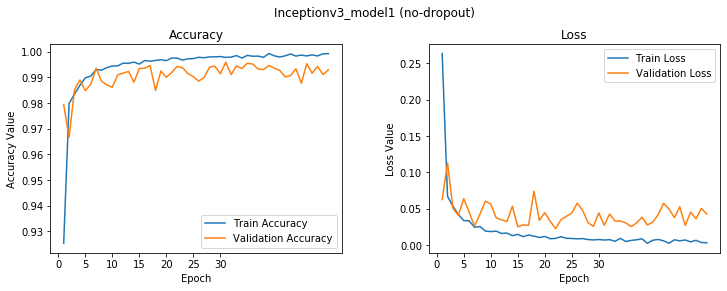

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Inceptionv3_model1 (no-dropout)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
#ax1.savefig('accuracy.png')

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
#ax2.savefig('loss.png')

f.savefig('InceptionV3_model1_15_categories_54305_images.png')

In [31]:
iv3_model.save('InceptionV3_model1_15_categories_54305_images.h5')